In [1]:
from Game import *
from Game.minimax import *

Version:  0.3.02


## Nim 

In [2]:
def initial_state(): 
    """ returns  - The initial state of the game"""
    return 21

def valid_moves(state,player):
    """returns  - a list of the valid moves for the state and player"""

    if state==2:
        return [1,2]
    elif state==1:
        return [1]
    else:
        return [1,2,3]

def show_state(state,player):
    """prints or shows the current state"""
    print(f"There are >>{state} sticks<<< for player {player}.")

def update_state(state,player,move):
    """returns  - the new state after the move for the player"""

    new_state=state-move

    return new_state


def win_status(state,player):
    """    returns  - 'win'  if the state is a winning state for the player, 
               'lose' if the state is a losing state for the player,
               'stalemate' for a stalemate
               None otherwise
    """

    if state==0:
        return 'lose'

    if state==1:
        return 'win'


    return None
    


## Agents

In [3]:
def random_move(state,player):    
    moves=valid_moves(state,player)
    return random.choice(moves)

random_agent=Agent(random_move)

def human_move(state,player):
    print("Player ", player)
    valid_move=False
    while not valid_move:
        move=int(input('What is your move? '))

        if move in valid_moves(state,player):
            valid_move=True
        else:
            print("Illegal move.")

    return move

human_agent=Agent(human_move)

In [4]:
def minimax_move(state,player):
    values,moves=minimax_values(state,player,display=False)
    return top_choice(moves,values)


minimax_agent=Agent(minimax_move)

In [5]:
def skittles_move(state,player,info):
    S=info.S
    last_state=info.last_state
    last_action=info.last_action
    verbose=info.verbose

    
    if verbose:
        print("\t","Player ",player," is thinking...")
        print("\t","State: ",state)
        print("\t","Table:",S)
        print("\t","Last state,action: ",last_state,last_action)
    
    # make/adjust the table

    if state not in S:
        # add a row to the table for each move
        S[state]=Table()
        moves=valid_moves(state,player)
        for action in moves:
            S[state][action]=3  # number of skittles/beads for each move
    
        if verbose:
            print("\t","State ",state,"unknown...added to table")
            print("\t","Table",S)
    
    move=weighted_choice(S[state])
    if verbose:
        print("\t","Choosing from S[",state,"]",S[state],"....Move: ",move)

    if move is None:  # there are no skittles in this row
        if last_state:
            if verbose:
                print("\t","No possible moves!")
                print("\t","Modifying the table: removing one skittle from (state,action) ",last_state,last_action)
            S[last_state][last_action]=S[last_state][last_action]-1
            
            if verbose:
                print("\t","Table:",S)
                
            if S[last_state][last_action]<0:                
                S[last_state][last_action]=0
                if verbose:
                    print("\t","Negative skittles...fixing.")
                    print("\t","Table:",S)                
        else:
            if verbose:
                print("\t","Started in a bad state ",state,"with no moves and no last state.  Won't modify table.")
                  
                  

        move=random_move(state,player)

    
    return move

def skittles_after(status,player,info):
    S=info.S
    last_state=info.last_state
    last_action=info.last_action
    verbose=info.verbose

    if verbose:
        print("\t","End of Game adjustments")
        print("\t","Player ",player," is thinking...")
        print("\t","Win Status: ",status)
        print("\t","Table:",S)
        print("\t","Last state,action: ",last_state,last_action)
        
    if status=='lose':
        if last_state:
            S[last_state][last_action]=S[last_state][last_action]-1
            if S[last_state][last_action]<0:
                S[last_state][last_action]=0
                
            if verbose:
                print("\t","Modifying the table: removing one skittle from (state,action) ",last_state,last_action)
                print("\t","Table:",S)

                
        else:
            if verbose:
                print("\t","No last state, so nothing to learn.")
            
                
    else:
        if verbose:
            print("\t","No adjustments needed.")
        
    # does this double-count the learning if you lose on your own turn        
    

In [6]:
skittles_agent1=Agent(skittles_move)
skittles_agent1.S=Table()
skittles_agent1.post=skittles_after
skittles_agent1.verbose=False

skittles_agent2=Agent(skittles_move)
skittles_agent2.S=Table()
skittles_agent2.post=skittles_after
skittles_agent2.verbose=False

In [7]:
def perfect_move(state,player):
    move=(state-1)%4

    if move==0:  # bad state
        move=1

    return move

perfect_agent=Agent(perfect_move)

In [8]:
g=Game()
g.run(skittles_agent1,skittles_agent2)

====
Game  1
There are >>21 sticks<<< for player 1.
Player 1 moves 1
There are >>20 sticks<<< for player 2.
Player 2 moves 3
There are >>17 sticks<<< for player 1.
Player 1 moves 2
There are >>15 sticks<<< for player 2.
Player 2 moves 3
There are >>12 sticks<<< for player 1.
Player 1 moves 3
There are >>9 sticks<<< for player 2.
Player 2 moves 2
There are >>7 sticks<<< for player 1.
Player 1 moves 2
There are >>5 sticks<<< for player 2.
Player 2 moves 3
There are >>2 sticks<<< for player 1.
Player 1 moves 2
There are >>0 sticks<<< for player 1.
Player  2 won.


[2]

In [9]:
SaveTable(skittles_agent1.S,'nim skittles1.json')
SaveTable(skittles_agent2.S,'nim skittles2.json')

In [10]:
%matplotlib inline
from matplotlib.pyplot import figure,plot,grid,legend,xlabel,ylabel,title
from tqdm import tqdm

In [11]:
agent1=skittles_agent1
agent1.S=Table()

agent2=skittles_agent2
agent2.S=Table()

In [12]:
S=Storage()
one,two,ties,N=0,0,0,0

In [13]:
for i in tqdm(range(30)):
    g=Game(number_of_games=100)
    g.display=False
    
    result=g.run(agent1,agent2)
    one,two,ties,N=one+result.count(1),two+result.count(2),ties+result.count(0),N+len(result)
    
    S+=one/N*100,two/N*100,ties/N*100,N
    
y1,y2,y0,x=S.arrays()    

100%|███████████████████████████████████████████| 30/30 [00:00<00:00, 94.23it/s]


Text(0, 0.5, 'Percent')

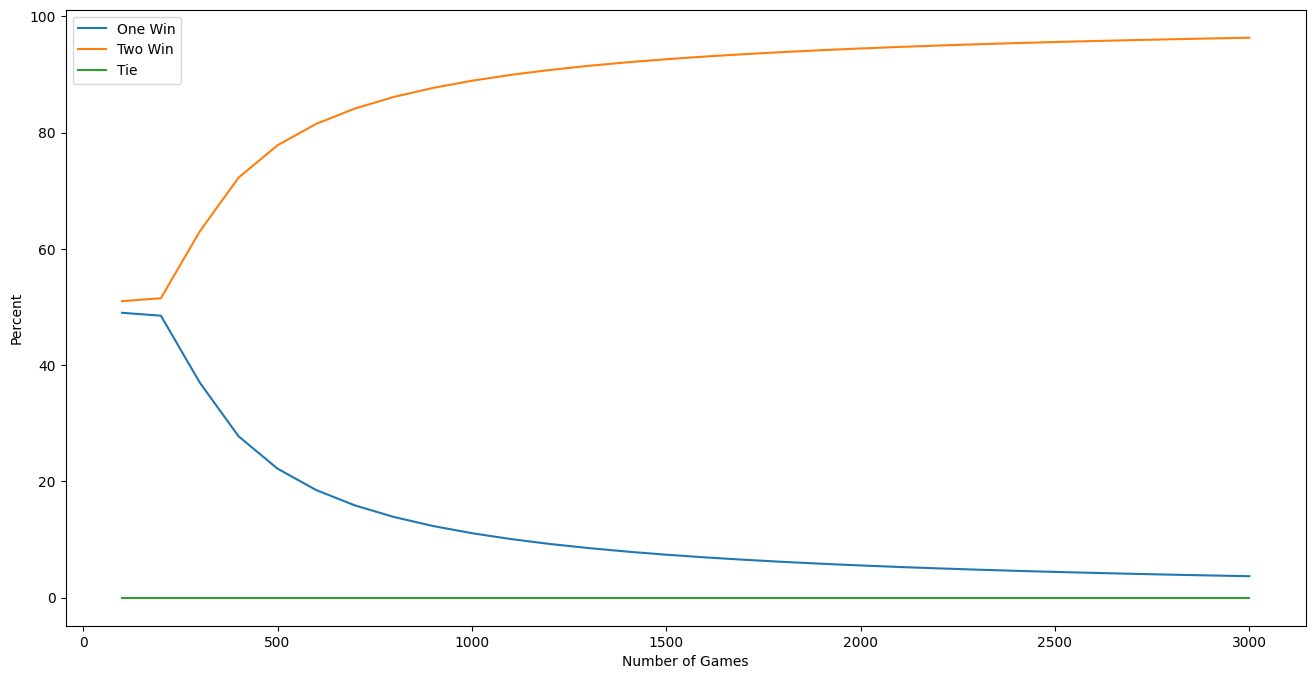

In [14]:
figure(figsize=(16,8))
plot(x,y1,label='One Win')
plot(x,y2,label='Two Win')
plot(x,y0,label='Tie')
legend()
xlabel('Number of Games')
ylabel('Percent')

In [15]:
SaveTable(skittles_agent1.S,'nim skittles1.json')
SaveTable(skittles_agent2.S,'nim skittles2.json')

## Test the agent

In [ ]:
g=Game()
g.run(human_agent,skittles_agent2)

In [17]:
g=Game(number_of_games=100)
g.display=False
result=g.run(minimax_agent,agent2)
g.report()

Total number of games:  100
Winning 0.00 percent
Losing 100.00 percent
Tie 0.00 percent
